In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path

from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

In [2]:
lccs_resolution = 300 #m
areapergrid = (300/1000) ** 2 ## km2

weight_wind = [
    0.0632, #landuse
    0.0502, #slope
    0.0942, #elevation
    0.0772, #d to settlement
    0.0192, #d to wetland
    0.0302, #d to forest
    0.0502, #prox to road
    0.0942, #prox to sub
    0.2672, #Resource quality
    0.2532 #Farm Required area
    ]
print('weight_wind = ',sum(weight_wind))

weight_solar = [
    0.1433, #landuse
    0.1293, #slope
    0.0663, #elevation
    0.0603, #d to settlement
    0.0363, #d to wetland
    0.0143, #d to forest
    0.0503, #prox to road
    0.1023, #prox to sub
    0.2573, #Resource quality
    0.1383 #Farm Required area
    ]
print('weight_solar = ' , sum(weight_solar))

print('areapergrid = ',areapergrid)

weight_wind =  0.999
weight_solar =  0.998
areapergrid =  0.09


In [3]:
## Create teh final SI map template ###
xr_final_SI = xr.open_dataset('Output\\xr_SI_Landcover.nc')
xr_final_SI = xr_final_SI.drop_vars('lccs_class')
xr_final_SI = xr_final_SI.drop_vars('SI_BGEC')
xr_final_SI = xr_final_SI.drop_vars('SI_Biomass')
xr_final_SI = xr_final_SI.drop_vars('SI_BGWW')
xr_final_SI = xr_final_SI.drop_vars('SI_MSW')
xr_final_SI = xr_final_SI.drop_vars('SI_IEW')

xr_final_SI['AVA_Wind'] = xr_final_SI['SI_Wind']
xr_final_SI['AVA_Solar'] = xr_final_SI['SI_Solar']

xr_final_SI['SI_Wind'] = 0.0
xr_final_SI['SI_Solar'] = 0.0
xr_final_SI['AVA_Wind'] = 0.0
xr_final_SI['AVA_Solar'] = 0.0
print(xr_final_SI)
check_weight_wind = 0
check_weight_solar = 0

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   float64 0.0
    SI_Wind    float64 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   float64 0.0
    AVA_Solar  float64 0.0


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.0632
check w solar =  0.1433
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(136859.94)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(136859.94)


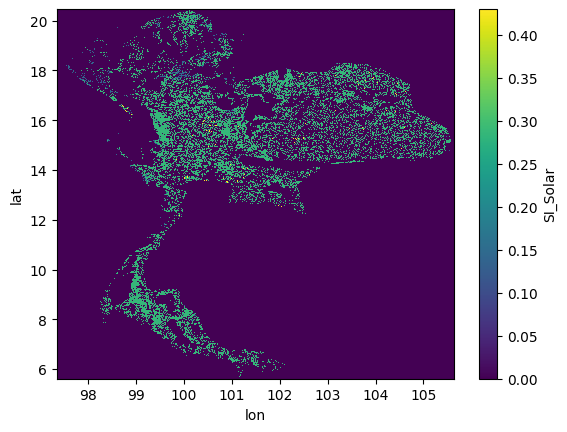

In [4]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_landuse_suitability_index['SI_Wind'] * weight_wind[0])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_landuse_suitability_index['SI_Solar'] * weight_solar[0])
xr_final_SI['AVA_Wind'] = xr.where(xr_landuse_suitability_index['SI_Wind'] > 0 ,0.09,0)
xr_final_SI['AVA_Solar'] = xr.where(xr_landuse_suitability_index['SI_Solar'] > 0 ,0.09,0)

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[0]
check_weight_solar = check_weight_solar + weight_solar[0]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

In [5]:
xr_cal = xr.open_dataset('Output\\xr_SI_Slope.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[1])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[1])

# cutout area for slope 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[1]
check_weight_solar = check_weight_solar + weight_solar[1]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.1134
check w solar =  0.2726
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(131069.07)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(113528.07)


In [6]:
xr_cal = xr.open_dataset('Output\\xr_SI_Elevation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[2])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[2])

## Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[2]
check_weight_solar = check_weight_solar + weight_solar[2]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.2076
check w solar =  0.3389
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(96765.75)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90507.33)


In [7]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosettlementarea.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[3])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[3])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[3]
check_weight_solar = check_weight_solar + weight_solar[3]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.2848
check w solar =  0.3992
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(90451.98)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(84284.19)


In [8]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetowetland.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[4])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[4])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[4]
check_weight_solar = check_weight_solar + weight_solar[4]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.304
check w solar =  0.4355
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(87461.64)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(81359.01)


In [9]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoforest.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[5])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[5])

xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[5]
check_weight_solar = check_weight_solar + weight_solar[5]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.3342
check w solar =  0.4498
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64936.62)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67813.2)


In [10]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoroad.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[6])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[6])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[6]
check_weight_solar = check_weight_solar + weight_solar[6]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.3844
check w solar =  0.5001
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.91)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.36)


In [11]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosubstation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[7])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[7])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[7]
check_weight_solar = check_weight_solar + weight_solar[7]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.4786
check w solar =  0.6024
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.91)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.36)


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.7458
check w solar =  0.8597
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.926, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.4, dtype=float32)


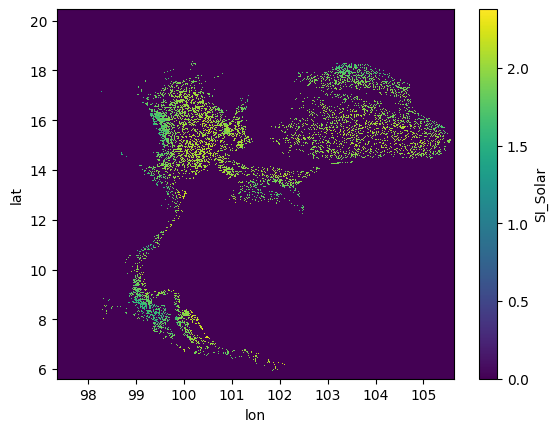

In [12]:
xr_cal = xr.open_dataset('Output\\xr_SI_resourcepotential.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[8])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[8])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar']  == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'].astype('float32')
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'].astype('float32')
xr_final_SI['AVA_Wind'] = xr_final_SI['AVA_Wind'].astype('float32')
xr_final_SI['AVA_Solar'] = xr_final_SI['AVA_Solar'].astype('float32')

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[8]
check_weight_solar = check_weight_solar + weight_solar[8]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

In [13]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

suitablearea_wind = 4 #km2
suitablearea_solar = 0.4  #km2

rolgridsuitablearea_wind = int(np.ceil(np.sqrt(suitablearea_wind/areapergrid)))
rolgridsuitablearea_solar = int(np.ceil(np.sqrt(suitablearea_solar/areapergrid)))

print('rolgridsuitablearea_wind = ',rolgridsuitablearea_wind)
print('rolgridsuitablearea_solar = ',rolgridsuitablearea_solar)

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())


rolgridsuitablearea_wind =  7
rolgridsuitablearea_solar =  3
Check w wind =  0.7458
check w solar =  0.8597
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.926, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.4, dtype=float32)
Max SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.02579975)
Max SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2.37837744)


In [14]:
xr_final_SI['FRA_SI_Wind'] = xr_final_SI['AVA_Wind'].rolling(lon = rolgridsuitablearea_wind, lat = rolgridsuitablearea_wind, min_periods=1,center=True).sum()
xr_final_SI['FRA_SI_Solar'] = xr_final_SI['AVA_Solar'].rolling(lon = rolgridsuitablearea_solar, lat = rolgridsuitablearea_solar, min_periods=1,center=True).sum()
xr_final_SI['FRA_SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['FRA_SI_Wind'])
xr_final_SI['FRA_SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['FRA_SI_Solar'])
print(xr_final_SI)

<xarray.Dataset>
Dimensions:       (lat: 5346, lon: 2985)
Coordinates:
  * lat           (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon           (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object ...
    A_BGEC        (lat, lon) float64 ...
    A_Biomass     (lat, lon) float64 ...
    A_BGWW        (lat, lon) float64 ...
    A_MSW         (lat, lon) float64 ...
    A_IEW         (lat, lon) float64 ...
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FRA_SI_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FRA_SI_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object ...
    A_BGEC     (lat, lon) float64 ...
    A_Biomass  (lat, lon) float64 ...
    A_BGWW     (lat, lon) float64 ...
    A_MSW      (lat, lon) float64 ...
    A_IEW      (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.999
check w solar =  0.998
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.926, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.4, dtype=float32)
Max SI Wind =  <

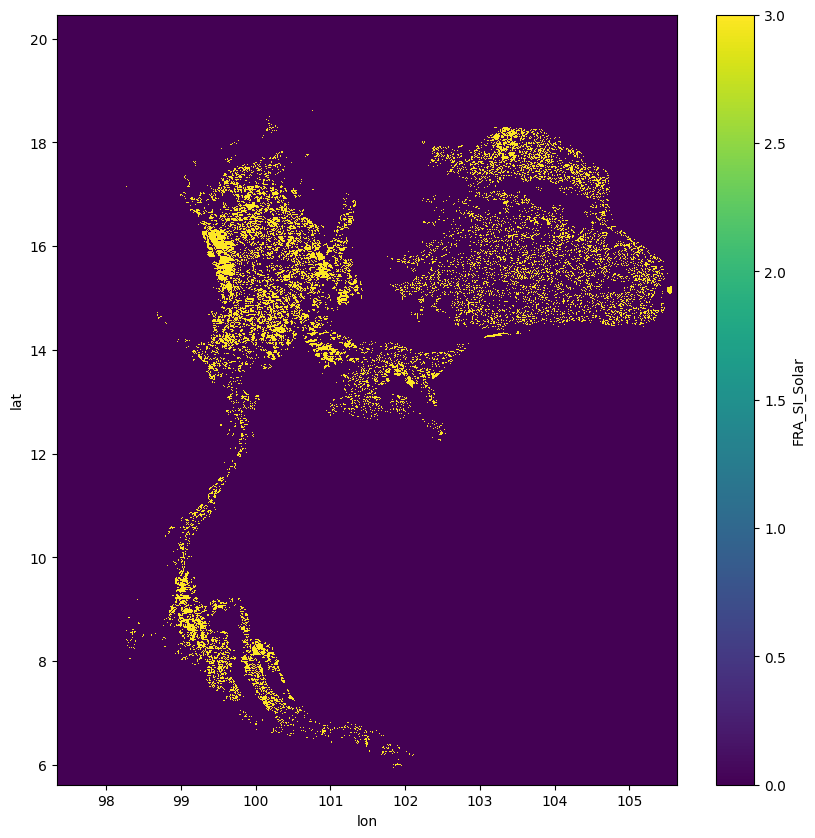

In [15]:
###### Wind ########
xr_final_SI['FRA_SI_Wind'] = xr.where( xr_final_SI['FRA_SI_Wind'] >= suitablearea_wind,3,0)
###### Solar ########
xr_final_SI['FRA_SI_Solar'] = xr.where( xr_final_SI['FRA_SI_Solar'] >= suitablearea_solar,3,0)

xr_final_SI['FRA_SI_Solar'].plot(figsize=(10,10))

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_final_SI['FRA_SI_Wind'] * weight_wind[9])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_final_SI['FRA_SI_Solar'] * weight_solar[9])

xr_final_SI['AVA_Wind'] = xr.where(xr_final_SI['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_final_SI['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

check_weight_wind = check_weight_wind + weight_wind[9]
check_weight_solar = check_weight_solar + weight_solar[9]

xr_final_SI = xr_final_SI.drop_vars('FRA_SI_Wind')
xr_final_SI = xr_final_SI.drop_vars('FRA_SI_Solar')
print(xr_final_SI)

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())

# xr_final_SI['SI_Wind'].plot()

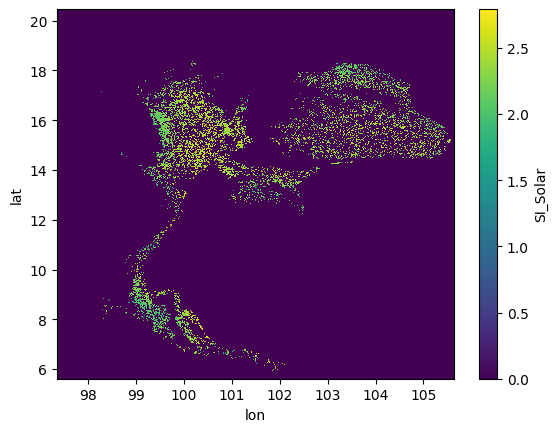

In [16]:
xr_final_SI['SI_Solar'].plot()

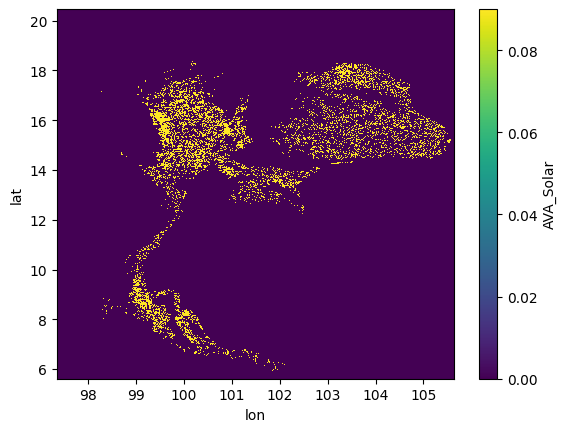

In [17]:
xr_final_SI['AVA_Solar'].plot()

In [18]:
xr_final_SI.to_netcdf(path='Output\\xr_final_SI.nc')

#############################################################################################################################